# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.routines as rt

In [2]:
# datasets = [
# #             ds.accident_small_samp_data,
#             ds.adult_small_samp_data,
#             ds.bankmark_samp_data,
#             ds.car_data,
#             ds.cardiotography_data,
#             ds.credit_data,
#             ds.german_data,
#             ds.lending_tiny_samp_data,
#             ds.nursery_samp_data,
#             ds.rcdv_samp_data
#            ]

### common config - can be ommitted if defaults are OK

In [3]:
project_dir = 'V:\\whiteboxing' # defaults to a directory "whiteboxing" in the working directory
random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Create a wrapper for the dataset. 
#### Use one that ships with the package, or create your own.

In [4]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
mydata = ds.nursery_samp_data(random_state=random_state, project_dir=project_dir)
meta_data = mydata.get_meta()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build a random forest, tuned for high accuracy

####################### PARAMETER TUNING #######################
################### Only runs when required ####################
### Use the override_tuning = True to force a new tuning run ###
################################################################

best_params = rt.tune_rf(
 X=tt.X_train_enc,
 y=tt.y_train,
 save_path = mydata.make_save_path(), # override_tuning=False, # default
 random_state=mydata.random_state)

#### best_params are save to json at the save_path location ####
################################################################

# train a rf model. use onehot encoded training data
# so that cat vars are not converted to ordinal
# this is recommended practice with scikit-learn
# the data_split_container is a convenience wrapper with everything you need
rf = rt.train_rf(
 X=tt.X_train_enc,
 y=tt.y_train,
 best_params=best_params,
 random_state=mydata.random_state)

using previous tuning parameters


# evaluate the model and plot a confusion matrix

Confusion matrix, without normalization
[[254   0   0   0]
 [  0 252   9   0]
 [  0  10 231   0]
 [  0  15   0   7]]


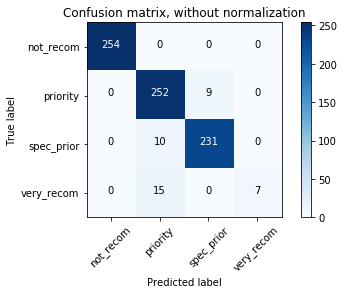

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.97 0.03 0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.68 0.   0.32]]


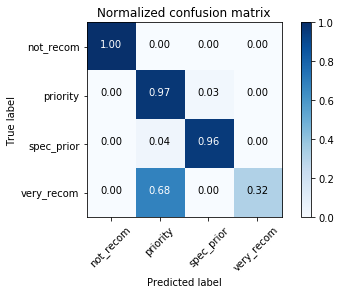

In [5]:
# the outputs of this function are:
# cm - confusion matrix as 2d array
# acc - accuracy of model = correctly classified instance / total number instances
# coka - Cohen's kappa score. Accuracy adjusted for probability of correct by random guess. Useful for multiclass problems
# prfs - precision, recall, f-score, support with the following signatures as a 2d array
# 0 <= p, r, f <= 1. s = number of instances for each true class label (row sums of cm)
cm, acc, coka, prfs = rt.evaluate_model(prediction_model=rf, X=tt.X_test_enc, y=tt.y_test,
             class_names=mydata.get_label(mydata.class_col, [i for i in range(len(mydata.class_names))]).tolist(),
             plot_cm=True, plot_cm_norm=True) # False here will output the metrics and suppress the plots

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [6]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=False
chirps_explanation_async=False

# the number of instances can be controlled by
# batch_size - how many instances to explain at one time
batch_size = 5
# how many instances to explain in total from a test/unseen set
n_instances = 10000 

# this will normalise the above parameters to the size of the dataset
rt.batch_instance_ceiling(data_split=tt, n_instances=n_instances, batch_size=batch_size)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
instances, instances_enc, instances_enc_matrix, labels = tt.get_next(batch_size, which_split='test') # default

option 2: just run the whole test set

In [7]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make all the model predictions from the decision forest
Important point, no compromise on model accuracy

In [8]:
# get all the model predictions for the instances we're looking at
pred_indices = labels.index
pred_labels = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [9]:
# wrapper object needs the decision forest itself and the dataset meta data (we have a convenience function for this)
f_walker = strcts.forest_walker(forest = rf, meta_data=meta_data)

Now the work of extracting all the paths for each instance is done

In [10]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - returns a batch_paths_container (even for just one instance)
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
bp_container = f_walker.forest_walk(instances = instances_enc_matrix
                        , labels = pred_labels
                        , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 5 instances... (please wait)
Forest Walk with async = False
Forest Walk time elapsed: 0.9850 seconds


# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [11]:
# build CHIRPS and a rule for each instance represented in the batch paths container
CHIRPS = strcts.batch_CHIRPS_explainer(bp_container,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                sample_labels=tt.y_train,  # any representative sample can be used
                                meta_data=meta_data)

print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.batch_run_CHIRPS(chirps_explanation_async=chirps_explanation_async) # all the defaults

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

Running CHIRPS on a batch of 5 instances... (please wait)
CHIRPS time elapsed: 2.0149 seconds
CHIRPS with async = False


In [12]:
# test set has been used to create an explainer *one instance at a time*
# rest of test set was not "seen" during construction of each explainer

# to score each explainer, we use test set, leaving out the individual instance being explained
# the data_split_container has a convenience funtion for this

# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

headers = ['instance_id', 'algorithm',
                'pretty rule', 'rule length',
                'pred class', 'pred class label',
                'target class', 'target class label',
                'majority voting trees', 'majority vote share', 'pred prior',
                'precision(tr)', 'recall(tr)', 'f1(tr)',
                'accuracy(tr)', 'lift(tr)',
                'total coverage(tr)',
                'precision(tt)', 'recall(tt)', 'f1(tt)',
                'accuracy(tt)', 'lift(tt)',
                'total coverage(tt)', 'model_acc', 'model_ck']
output = [[]] * len(CHIRPS.CHIRPS_explainers)

for i, c in enumerate(CHIRPS.CHIRPS_explainers):
    
    # instance meta data
    alg = c.algorithm
    instance_id = pred_indices[i]
    mc = c.major_class
    mc_lab = c.major_class_label
    tc = c.target_class
    tc_lab = c.target_class_label
    vt = c.model_votes['counts'][tc]
    mvs = c.model_posterior[tc]
    prior = c.posterior[0][tc]
    rule = c.pruned_rule
    pretty_rule = c.prettify_rule()
    rule_len = len(rule)
    # final metrics from rule merge step (usually based on training set)
    tr_prec = list(reversed(c.posterior))[tc]
    tr_recall = list(reversed(c.recall))[tc]
    tr_f1 = list(reversed(c.f1))[tc]
    tr_acc = list(reversed(c.accuracy))[tc]
    tr_lift = list(reversed(c.lift))[tc]
    tr_coverage = list(reversed(c.coverage))
    
    # get test sample by leave-one-out on current instance
    instances, instances_enc, labels = tt.get_loo_instances(instance_id)
    # then evaluating rule metrics on test set
    eval_rule = c.evaluate_rule(rule=c.pruned_rule, instances=instances_enc, labels=labels)
    
    # collect results
    tt_prec = eval_rule['post'][tc]
    tt_recall = eval_rule['recall'][tc]
    tt_f1 = eval_rule['f1'][tc]
    tt_acc = eval_rule['accuracy'][tc]
    tt_lift = eval_rule['lift'][tc]
    tt_coverage = eval_rule['coverage']
    
    output[i] = [instance_id,
        alg,
        pretty_rule,
        rule_len,
        mc,
        mc_lab,
        tc,
        tc_lab,
        vt,
        mvs,
        prior,
        tr_prec,
        tr_recall,
        tr_f1,
        tr_acc,
        tr_lift,
        tr_coverage,
        tt_prec,
        tt_recall,
        tt_f1,
        tt_acc,
        tt_lift,
        tt_coverage,
        acc,
        coka]
    print('instance id: ' + str(instance_id) + ' with target class ' + str(tc) + ' (' + tc_lab + ')')
    print('rule: ' + pretty_rule)
    print()
    print('rule precision (unseen data) ' + str(tt_prec))
    print('rule coverage (unseen data) ' + str(tt_coverage))
    print('rule f1 score (unseen data) ' + str(tt_f1))
    print('rule lift (unseen data) ' + str(tt_lift))
    print('unseen data prior counts ' + str(eval_rule['priors']['counts']))
    print('rule posterior counts ' + str(eval_rule['counts']))
    print('rule chisq p-value ' + str(eval_rule['chisq'][1]))
    print()
    print()
    
results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

evaluating found explanations

instance id: 33 with target class 1 (priority)
rule: has_nurs_critical False AND has_nurs_very_crit False AND has_nurs_improper False AND health_priority True AND parents_great_pret False

rule precision (unseen data) 1.0
rule coverage (unseen data) 0.09395109395109395
rule f1 score (unseen data) 0.4384384384384385
rule lift (unseen data) 31.808693361433086
unseen data prior counts [254 260 241  22]
rule posterior counts [ 0 73  0  0]
rule chisq p-value 1.0695784116657522e-26


instance id: 2269 with target class 2 (spec_prior)
rule: has_nurs_very_crit True AND health_not_recom False AND children_1 False AND parents_usual False AND housing_convenient False

rule precision (unseen data) 0.96
rule coverage (unseen data) 0.032175032175032175
rule f1 score (unseen data) 0.1811320754716981
rule lift (unseen data) 96.59664000000001
unseen data prior counts [254 261 240  22]
rule posterior counts [ 0  1 24  0]
rule chisq p-value 4.2971369466189766e-10


instance